### Imports

In [60]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import math 
import os 

### Visualization Functions

In [61]:
# Function to save and plot SIRV proportions
def saveAndPlotSIRVProportions(S, I_var, R, X, population, I, T, output_folder):
    # Load county names from the inputData folder
    county_names_path = os.path.join("inputData", "floridaCountyNames.csv")
    county_names_df = pd.read_csv(county_names_path)
    county_names = county_names_df["County"].tolist()

    # Collect SIRV proportions data
    sirvData = []
    for i in I:
        for t in T:
            total_population = population[i]
            s_prop = S[i, t].x / total_population if total_population > 0 else 0
            i_prop = I_var[i, t].x / total_population if total_population > 0 else 0
            r_prop = R[i, t].x / total_population if total_population > 0 else 0
            x_prop = X[i, t].x / total_population if total_population > 0 else 0
            sirvData.append([i, t, s_prop, i_prop, r_prop, x_prop])
    
    sirvDf = pd.DataFrame(sirvData, columns=["region", "timePeriod", "S_proportion", "I_proportion", "R_proportion", "X_proportion"])
    sirv_csv_path = os.path.join(output_folder, "sirvProportions.csv")
    sirvDf.to_csv(sirv_csv_path, index=False)
    print(f"SIRV proportions data saved to '{sirv_csv_path}'")

    numRegions = len(I)
    rows = 23
    cols = math.ceil(numRegions / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 60), sharex=True, sharey=True)
    fig.suptitle("SIRV Proportions Over Time for Each County", fontsize=16, y=0.95) 
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to reduce gap

    for idx, i in enumerate(I):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        regionData = sirvDf[sirvDf["region"] == i]
        county_name = county_names[i - 1]  # Access county name using region index
        ax.plot(regionData["timePeriod"], regionData["S_proportion"], label="S", color="blue")
        ax.plot(regionData["timePeriod"], regionData["I_proportion"], label="I", color="red")
        ax.plot(regionData["timePeriod"], regionData["R_proportion"], label="R", color="green")
        ax.plot(regionData["timePeriod"], regionData["X_proportion"], label="V", color="orange")
        ax.set_title(county_name, fontsize=10)  # Set title using county name
        ax.grid(True)
        
        # Add legend to each subplot
        ax.legend(loc="upper right", fontsize=6)

        if row == rows - 1:
            ax.set_xlabel("Time Period")
        if col == 0:
            ax.set_ylabel("Proportion")

    plot_path = os.path.join(output_folder, "sirvProportions.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"SIRV proportions plot saved to '{plot_path}'")
    plt.show()


# Function to save travel and vaccine allocation data
def saveTravelAndVaccineData(Z, A, I, J, T_prime, output_folder):
    travelData = []
    for i in I:
        for j in J:
            for tPrime in T_prime:
                quantity = Z[i, j, tPrime].x
                if quantity > 0:
                    travelData.append([i, j, tPrime, quantity])
    
    travel_csv_path = os.path.join(output_folder, "travelData.csv")
    travelDf = pd.DataFrame(travelData, columns=["fromRegion", "toFacility", "timePeriod", "quantity"])
    travelDf.to_csv(travel_csv_path, index=False)
    print(f"Travel data saved to '{travel_csv_path}'")

    vaccineAllocationData = []
    for i in I:
        for tPrime in T_prime:
            quantity = A[i, tPrime].x
            if quantity > 0:
                vaccineAllocationData.append([i, tPrime, quantity])

    vaccine_csv_path = os.path.join(output_folder, "vaccineAllocationData.csv")
    vaccineAllocationDf = pd.DataFrame(vaccineAllocationData, columns=["region", "timePeriod", "allocatedVaccines"])
    vaccineAllocationDf.to_csv(vaccine_csv_path, index=False)
    print(f"Vaccine allocation data saved to '{vaccine_csv_path}'")


### Run the Model

In [62]:
# Load data files
distanceDF = pd.read_csv("inputData/Distance.csv", header=None)   # Distance between counties
capacityDF = pd.read_csv("inputData/Capacity.csv", header=None)   # Healthcare facility capacities
populationDF = pd.read_csv("inputData/Population.csv", header=None)  # Population per county
vaccineDF = pd.read_csv("inputData/Florida_Weekly_Vaccine_Summary.csv")  # Weekly vaccination data

# Define model parameters
t_B = 0                # Start time period
t_E = 26               # End time period (26 weeks)
psi = 1                # Decision interval
numCounties = 67       # Number of counties in Florida

# Define sets for counties, healthcare facilities, time periods, and decision periods
I = range(1, numCounties + 1)  # Set of regions (counties)
J = range(1, numCounties + 1)  # Set of healthcare facilities
T = range(t_B, t_E + 1)        # Set of time periods
T_prime = range(t_B, t_E + 1, psi)  # Set of decision-making time periods

# Initial values for SIRV model (actual populations)
population = {i: populationDF.iloc[i-1, 0] for i in I}  # Population in each county

initial_S_fraction = 0.99
initial_I_fraction = 0.01
initial_R_fraction = 0.00
initial_X_fraction = 0.1

initial_S = {i: population[i] * initial_S_fraction for i in I}  # Initial susceptible population
initial_I = {i: population[i] * initial_I_fraction for i in I}  # Initial infected population
initial_R = {i: population[i] * initial_R_fraction for i in I}  # Initial recovered population
initial_X = {i: population[i] * initial_X_fraction for i in I}  # Initial vaccinated population

# Model parameters with example values
beta = {i: 0.12 for i in I}       # Transmission rate for each county
gamma = {i: 0.98 for i in I}     # Recovery rate for each county
l = {i: 0.05 for i in I}         # Leaky vaccine probability for each county
rho = {i: 0.0001 for i in I}      # Hospitalization rate for each county
C = {j: capacityDF.iloc[j-1, 0] for j in J}  # Capacity at each healthcare facility
V_total = {t: 1000 for t in T_prime}  # Total vaccines available at each decision period
d = {(i, j): distanceDF.iloc[i-1, j-1] for i in I for j in J}  # Distance between counties
D_max = 100                    # Max travel distance allowed for healthcare
N = population                  # Total population in each county
M = 1e6                         # Large number for big-M constraints in linear programming

# Ensure the output folder exists
output_folder = "outputData"
os.makedirs(output_folder, exist_ok=True)

# Initialize Gurobi model
model = gp.Model("SIRV_Model")

# Define decision variables
S = model.addVars(I, T, lb=0, ub=N, name="S")          # Susceptible population per county and time
I_var = model.addVars(I, T, lb=0, ub=N, name="I")      # Infected population per county and time
R = model.addVars(I, T, lb=0, ub=N, name="R")          # Recovered population per county and time
X = model.addVars(I, T, lb=0, ub=N, name="X")          # Vaccinated population per county and time
v = model.addVars(I, T, lb=0, name="v")                # Vaccinations administered per county and time
H = model.addVars(I, T, lb=0, name="H")                # Hospitalized population per county and time
A = model.addVars(I, T_prime, lb=0, name="A")          # Vaccines allocated per county and decision period
Z = model.addVars(I, J, T_prime, lb=0, name="Z")       # Number of people transferred for healthcare
U = model.addVars(I, T_prime, lb=0, name="U")          # Unmet healthcare demand per county and time
b = model.addVars(I, J, T_prime, vtype=GRB.BINARY, name="b")  # Binary travel variable
W_SI = model.addVars(I, T, lb=0, name="W_SI")          # Auxiliary variable for linearizing S*I
Z_XI = model.addVars(I, T, lb=0, name="Z_XI")          # Auxiliary variable for linearizing X*I

# Objective: Minimize total unmet healthcare demand
model.setObjective(gp.quicksum(U[i, t_prime] for i in I for t_prime in T_prime), GRB.MINIMIZE)

# Constraints
for i in I:
    for t in T:
        if t == t_B:
            model.addConstr(S[i, t] == initial_S[i])
            model.addConstr(I_var[i, t] == initial_I[i])
            model.addConstr(R[i, t] == initial_R[i])
            model.addConstr(X[i, t] == initial_X[i])
        else:
            model.addConstr(S[i, t] == S[i, t-1] - beta[i] * W_SI[i, t-1] - v[i, t-1])
            model.addConstr(I_var[i, t] == I_var[i, t-1] + beta[i] * (W_SI[i, t-1] + l[i] * Z_XI[i, t-1]) - gamma[i] * I_var[i, t-1])
            model.addConstr(R[i, t] == R[i, t-1] + gamma[i] * I_var[i, t-1])
            model.addConstr(X[i, t] == X[i, t-1] + v[i, t-1] - l[i] * beta[i] * Z_XI[i, t-1])
        model.addConstr(H[i, t] == rho[i] * I_var[i, t])

for i in I:
    for t_prime in T_prime:
        model.addConstr(U[i, t_prime] == H[i, t_prime] - gp.quicksum(Z[i, j, t_prime] for j in J))

for j in J:
    for t_prime in T_prime:
        model.addConstr(gp.quicksum(Z[i, j, t_prime] for i in I) <= C[j])

for t_prime in T_prime:
    model.addConstr(gp.quicksum(A[i, t_prime] for i in I) <= V_total[t_prime])

for i in I:
    for t_prime in T_prime:
        model.addConstr(v[i, t_prime] <= A[i, t_prime])

for i in I:
    for t in T:
        model.addConstr(v[i, t] <= S[i, t])

for i in I:
    for j in J:
        for t_prime in T_prime:
            model.addConstr(Z[i, j, t_prime] <= M * b[i, j, t_prime])
            model.addConstr(d[i, j] * b[i, j, t_prime] <= D_max)
            model.addConstr(Z[i, j, t_prime] >= 0)

for i in I:
    for t in T:
        model.addConstr(W_SI[i, t] >= 0)
        model.addConstr(W_SI[i, t] >= N[i] * I_var[i, t] + N[i] * S[i, t] - N[i] ** 2)
        model.addConstr(W_SI[i, t] <= N[i] * S[i, t])
        model.addConstr(W_SI[i, t] <= N[i] * I_var[i, t])
        model.addConstr(Z_XI[i, t] >= 0)
        model.addConstr(Z_XI[i, t] >= N[i] * I_var[i, t] + N[i] * X[i, t] - N[i] ** 2)
        model.addConstr(Z_XI[i, t] <= N[i] * X[i, t])
        model.addConstr(Z_XI[i, t] <= N[i] * I_var[i, t])

# Optimize the model
model.optimize()



Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 394389 rows, 260496 columns and 794872 nonzeros
Model fingerprint: 0x76554ff4
Variable types: 139293 continuous, 121203 integer (121203 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 4e+06]
Presolve removed 377689 rows and 246790 columns
Presolve time: 0.18s
Presolved: 16700 rows, 13706 columns, 49040 nonzeros
Variable types: 13706 continuous, 0 integer (0 binary)

Root relaxation: objective -2.505322e-05, 3457 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0    

### Plot and Save Results

SIRV proportions data saved to 'outputData\sirvProportions.csv'
SIRV proportions plot saved to 'outputData\sirvProportions.png'


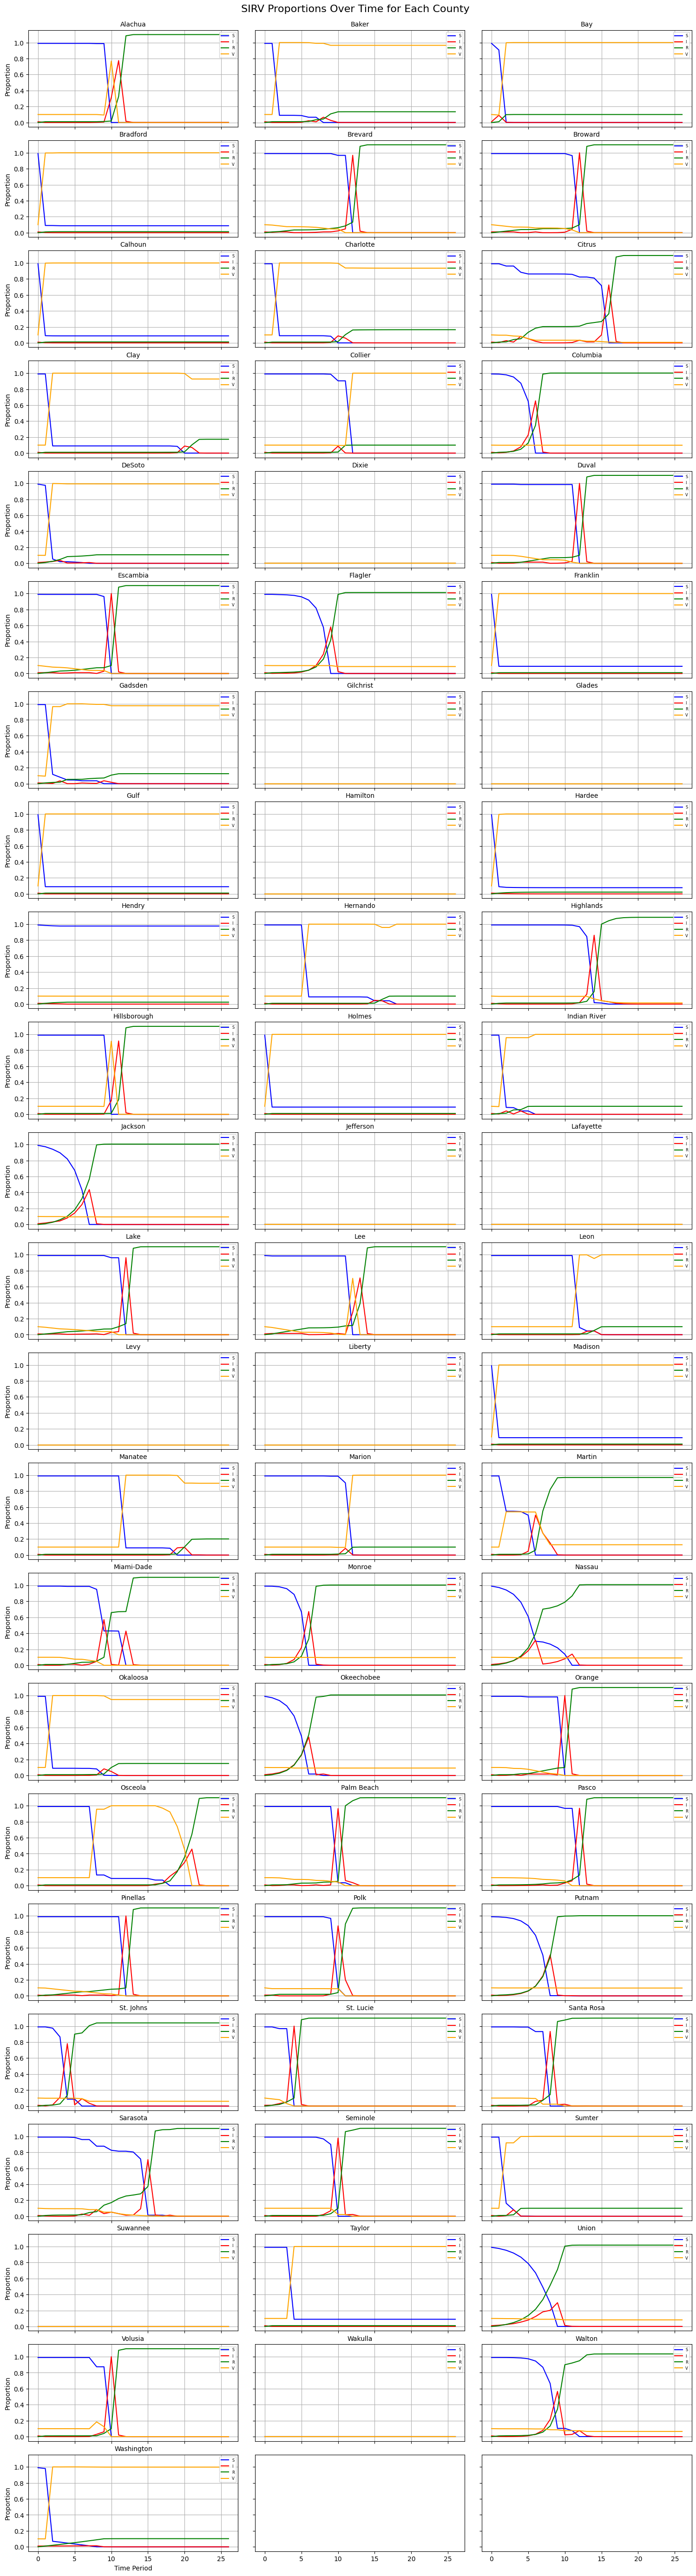

Travel data saved to 'outputData\travelData.csv'
Vaccine allocation data saved to 'outputData\vaccineAllocationData.csv'


In [63]:
if model.status == GRB.OPTIMAL:
    saveAndPlotSIRVProportions(S, I_var, R, X, population, I, T, output_folder)
    saveTravelAndVaccineData(Z, A, I, J, T_prime, output_folder)
else:
    print("No optimal solution found.")